In [1]:
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats as ss
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML,display
import tabulate

import random
from copy import deepcopy

%matplotlib inline

/home/outtoin/.pyenv/versions/3.6.2/envs/statistics-3.6.2/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv('./data/data.csv')
T1_df = df[df['Task'] == 'T1'].reset_index(drop=True)
T2_df = df[df['Task'] == 'T2'].reset_index(drop=True)
COM_df = df[df['Task'] == 'COM'].reset_index(drop=True)

In [3]:
T1_df.head()

,Participants No.,Task,Distance,Score,Trial
0,1,T1,9.1500,0,1
1,1,T1,7.5440,0,2
2,1,T1,7.1500,0,3
3,1,T1,6.6240,0,4
4,1,T1,6.2125,0,5


In [4]:
T2_df.head()

,Participants No.,Task,Distance,Score,Trial
0,1,T2,0.0,40,1
1,1,T2,0.0,40,2
2,1,T2,0.0,39,3
3,1,T2,0.0,40,4
4,1,T2,0.0,39,5


In [5]:
COM_df.head()

,Participants No.,Task,Distance,Score,Trial
0,1,COM,7.200000,22,1
1,1,COM,7.888000,20,2
2,1,COM,7.332000,18,3
3,1,COM,6.320833,16,4
4,1,COM,7.856000,24,5


### Visualization

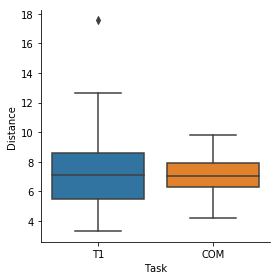

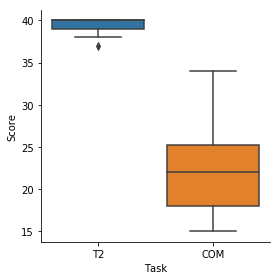

In [6]:
distance_df = pd.concat([T1_df[['Task','Distance']], COM_df[['Task','Distance']]])
score_df = pd.concat([T2_df[['Task', 'Score']], COM_df[['Task', 'Score']]])
ax = sns.factorplot(x='Task', y='Distance', data=distance_df, kind='box')
ax = sns.factorplot(x='Task', y='Score', data=score_df, kind='box')

### T-Test

In [7]:
print('Distance Average, T1: %.3f' % np.mean(T1_df['Distance']))
print('Distance Average, COM: %.3f' % np.mean(COM_df['Distance']))

Distance Average, T1: 7.440
Distance Average, COM: 7.176


In [8]:
print('Distance, T1 var %.3f' % np.std(T1_df['Distance']))
print('Distance, COM var %.3f' % np.std(COM_df['Distance']))

Distance, T1 var 2.831
Distance, COM var 1.320


In [9]:
tTestResult = stats.ttest_ind(T1_df['Distance'], COM_df['Distance'], equal_var=False)
print("The T-statistic and p-value between T1 and COM not assuming equal variances is %.3f and %.3f" % tTestResult)

The T-statistic and p-value between T1 and COM not assuming equal variances is 0.439 and 0.663


In [10]:
print('Score Average, T2: %.3f' % np.mean(T2_df['Score']))
print('Score Average, COM: %.3f' % np.mean(COM_df['Score']))

Score Average, T2: 39.433
Score Average, COM: 22.464


In [11]:
print('Score, T2 var %.3f' % np.std(T2_df['Score']))
print('Score, COM var %.3f' % np.std(COM_df['Score']))

Score, T2 var 0.761
Score, COM var 5.448


In [12]:
tTestResult = stats.ttest_ind(T2_df['Score'], COM_df['Score'], equal_var=False)
print("The T-statistic and p-value between task T2 and COM not assuming equal variances is %.3f and %.3f" % tTestResult)

The T-statistic and p-value between task T2 and COM not assuming equal variances is 16.041 and 0.000


### Cronbach's Alpha

In [13]:
def CronbachAlpha(items, rev=None):
    df = items.copy(deep=True)
    if rev is not None:
        for pair in rev:
            df[pair[0]] = df[pair[0]].apply(lambda x: pair[1] - x)
    
    itemvars = np.var(df, axis=0)
    nitems = len(df)
    slist = np.sum(df, axis=1)
    sumvar = np.var(slist)
    varsum = np.sum(itemvars)

    Calpha = ((nitems)/(nitems-1.)) * (1-(varsum/sumvar))
    
    return Calpha

In [14]:
def ingest(file):
    df = pd.read_csv(file).dropna(axis=1)
    vreq_df = df.filter(regex=("VREQ*"))
    spes_df = df.filter(regex=("SPES*"))
    tlx_df = df.filter(regex=("TLX*"))
    
    return [vreq_df, spes_df, tlx_df]

In [15]:
t1 = ingest('./data/T1.csv')
t2 = ingest('./data/T2.csv')
com = ingest('./data/combined.csv')

In [16]:
t1_with_sum = deepcopy(t1)
t2_with_sum = deepcopy(t2)
com_with_sum = deepcopy(com)

In [17]:
t1[0], t2[0], com[0] = t1[0].drop('VREQSUM', axis=1), t2[0].drop('VREQSUM', axis=1), com[0].drop('VREQSUM', axis=1)
t1[1], t2[1], com[1] = t1[1].drop('SPESSUM', axis=1), t2[1].drop('SPESSUM', axis=1), com[1].drop('SPESSUM', axis=1)
t1[2], t2[2], com[2] = t1[2].drop('TLX-SUM', axis=1), com[2].drop('TLX-SUM', axis=1), com[2].drop('TLX-SUM', axis=1),

In [18]:
table = [['', 'VREQ', 'SPES', 'TLX'],
         ['T1', round(CronbachAlpha(t1[0], [['VREQ9', 6]]), 3), round(CronbachAlpha(t1[1]), 3), round(CronbachAlpha(t1[2], [['TLX-Perf', 8]]), 3)],
         ['T2', round(CronbachAlpha(t2[0], [['VREQ9', 6]]), 3), round(CronbachAlpha(t2[1]), 3), round(CronbachAlpha(t2[2], [['TLX-Perf', 8]]), 3)],
         ['T3', round(CronbachAlpha(com[0], [['VREQ9', 6]]), 3), round(CronbachAlpha(com[1]), 3), round(CronbachAlpha(com[2], [['TLX-Perf', 8]]), 3)],
         ['ALL', round(CronbachAlpha(pd.concat([t1[0], t2[0], com[0]], axis=0), [['VREQ9', 6]]), 3), round(CronbachAlpha(pd.concat([t1[1], t2[1], com[1]], axis=0)), 3), round(CronbachAlpha(pd.concat([t1[2], t2[2], com[2]], axis=0), [['TLX-Perf', 8]]), 3)]]

display(HTML(tabulate.tabulate(table, tablefmt='html')))

,VREQ,SPES,TLX
T1,0.692,0.383,0.582
T2,0.841,0.757,0.59
T3,0.791,-0.018,0.59
ALL,0.627,0.663,0.698


### Visualization

In [19]:
def concatenate(l, label):
    assert(len(l) == len(label))
    li = []
    for i in range(len(l)):
        temp = l[i].copy(deep=True)
        temp['Task'] = pd.Series([label[i]] * len(temp))
        li.append(temp)
        
    return pd.concat(li)

In [20]:
label = ['T1', 'T2', 'COM']
vreq_df = concatenate([t1_with_sum[0], t2_with_sum[0], com_with_sum[0]], label)
spes_df = concatenate([t1_with_sum[1], t2_with_sum[1], com_with_sum[1]], label)
tlx_df = concatenate([t1_with_sum[2], t2_with_sum[2], com_with_sum[2]], label)

In [21]:
tlx_df.columns

Index(['TLX-Mental', 'TLX-Physical', 'TLX-Perf', 'TLX-Effort',
       'TLX-Frustration', 'TLX-SUM', 'Task'],
      dtype='object')

In [22]:
dfs = [vreq_df, spes_df, tlx_df]
df_labels = [['VREQ1', 'VREQ5', 'VREQ6', 'VREQ7', 'VREQ8', 'VREQ9', 'VREQ10', 'VREQSUM'], 
             ['SPES1', 'SPES2', 'SPES3', 'SPES4', 'SPESSUM'], 
             ['TLX-Mental', 'TLX-Physical', 'TLX-Perf', 'TLX-Effort', 'TLX-Frustration', 'TLX-SUM']]
for i in range(len(dfs)):
    print(df_labels[i][0])
    for l in label:
        tmp = dfs[i][dfs[i]['Task'] == l][df_labels[i]]
        print(np.median(tmp, axis=0))
        print(stats.iqr(tmp, axis=0))
        print('-' * 40)

VREQ1
[4.  5.  4.  4.  4.5 2.5 3.  4. ]
[0.25 1.   0.   1.   1.   2.   0.25 0.36]
----------------------------------------
[4.5   4.5   4.    4.5   2.    1.    4.    4.145]
[1.25   1.25   1.25   2.25   1.25   0.25   1.     1.1775]
----------------------------------------
[3.5   4.    4.    3.5   4.    4.    3.5   3.785]
[1.     1.     0.25   1.25   0.25   2.     1.     0.6075]
----------------------------------------
SPES1
[4.   5.   4.   3.5  4.25]
[0.25   0.25   2.     1.25   0.1875]
----------------------------------------
[3.  4.5 2.  2.5 2.5]
[2.5   2.25  1.25  2.    1.625]
----------------------------------------
[4.   5.   4.   4.   4.25]
[1.     0.25   0.25   1.     0.5625]
----------------------------------------
TLX-Mental
[3.  4.  4.5 4.5 2.  3.5]
[0.   1.25 1.   1.25 1.   0.9 ]
----------------------------------------
[1.  1.  6.  2.  1.  1.5]
[1.   0.   1.25 1.   0.25 0.45]
----------------------------------------
[5.5 6.  4.  7.  4.  5. ]
[1.25 0.5  0.5  0.25 0.25 0.55]
-

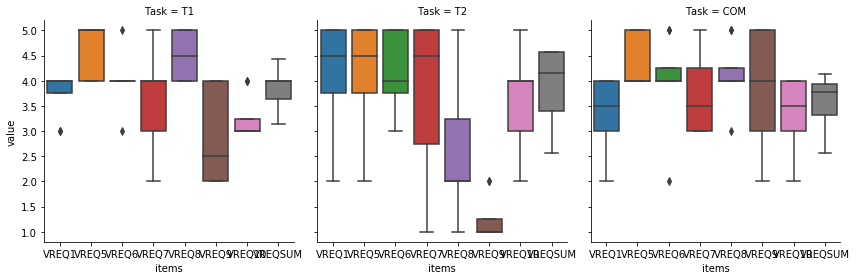

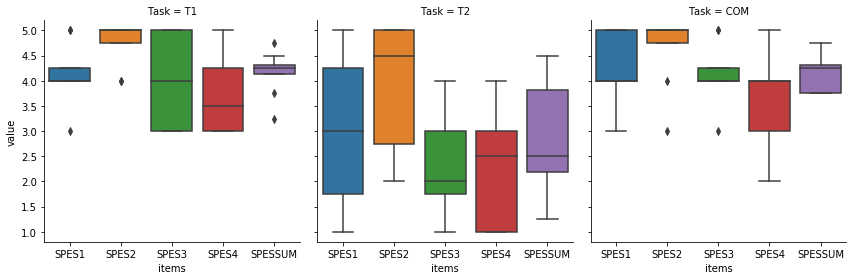

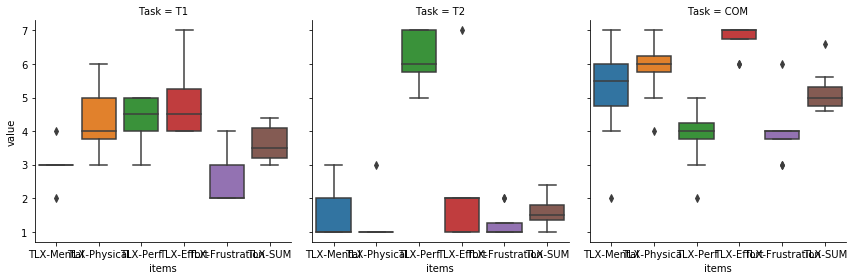

In [23]:
ax = sns.factorplot(x='items', y='value', col='Task', data=vreq_df.melt(id_vars=['Task'], var_name='items'), kind='box')
ax = sns.factorplot(x='items', y='value', col='Task', data=spes_df.melt(id_vars=['Task'], var_name='items'), kind='box')
ax = sns.factorplot(x='items', y='value', col='Task', data=tlx_df.melt(id_vars=['Task'], var_name='items'), kind='box')

### ANOVA

In [24]:
def onewayAnova(df, columns, rev=None):
    ret = []
    temp = df.copy(deep=True)
    if rev is not None:
        for pair in rev:
            temp[pair[0]] = df[pair[0]].apply(lambda x: pair[1] - x)
            
    for column in columns:
        tmpSeries = temp[[column, 'Task']]
        ret.append([column, stats.f_oneway(tmpSeries[tmpSeries['Task'] == 'T1'][column], 
                                           tmpSeries[tmpSeries['Task'] == 'T2'][column],
                                           tmpSeries[tmpSeries['Task'] == 'COM'][column])])
        
    return ret
        

In [25]:
vreq_columns = [x for x in vreq_df.columns if x is not 'Task']
spes_columns = [x for x in spes_df.columns if x is not 'Task']
tlx_columns = [x for x in tlx_df.columns if x is not 'Task']

vreq_stats = onewayAnova(vreq_df, vreq_columns, [['VREQ9', 6]])
spes_stats = onewayAnova(spes_df, spes_columns)
tlx_stats = onewayAnova(tlx_df, tlx_columns, [['TLX-Perf', 8]])

In [26]:
def make_table_elem(stats):
    li = []
    for stat in stats:
        li.append([stat[0], round(stat[1][0], 3), round(stat[1][1], 3)])
        
    return [['', 'F-value', 'p-value']] + li

In [27]:
display(HTML(tabulate.tabulate(make_table_elem(vreq_stats), tablefmt='html')))

,F-value,p-value
VREQ1,1.658,0.215
VREQ5,0.832,0.449
VREQ6,0.068,0.935
VREQ7,0.03,0.97
VREQ8,9.873,0.001
VREQ9,17.094,0.0
VREQ10,0.544,0.588
VREQSUM,0.517,0.603


In [28]:
display(HTML(tabulate.tabulate(make_table_elem(spes_stats), tablefmt='html')))

,F-value,p-value
SPES1,3.267,0.058
SPES2,2.062,0.152
SPES3,11.275,0.0
SPES4,5.575,0.011
SPESSUM,8.498,0.002


In [29]:
display(HTML(tabulate.tabulate(make_table_elem(tlx_stats), tablefmt='html')))

,F-value,p-value
TLX-Mental,24.366,0.0
TLX-Physical,51.741,0.0
TLX-Perf,15.008,0.0
TLX-Effort,22.663,0.0
TLX-Frustration,27.696,0.0
TLX-SUM,74.31,0.0


### Post-Hoc(Tukey)

In [30]:
def post_hoc_tukey(df, columns, rev=None):
    temp = df.copy(deep=True)
    if rev is not None:
        for pair in rev:
            temp[pair[0]] = df[pair[0]].apply(lambda x: pair[1] - x)
            
    for column in columns:
        res = pairwise_tukeyhsd(df[column], df['Task'])
        print('Tukey post-hoc of %s' % column)
        display(res.summary())   

In [31]:
post_hoc_tukey(vreq_df, vreq_columns, [['VREQ9', 6]])

Tukey post-hoc of VREQ1


group1,group2,meandiff,lower,upper,reject
COM,T1,0.375,-0.6629,1.4129,False
COM,T2,0.75,-0.2879,1.7879,False
T1,T2,0.375,-0.6629,1.4129,False


Tukey post-hoc of VREQ5


group1,group2,meandiff,lower,upper,reject
COM,T1,0.25,-0.7269,1.2269,False
COM,T2,-0.25,-1.2269,0.7269,False
T1,T2,-0.5,-1.4769,0.4769,False


Tukey post-hoc of VREQ6


group1,group2,meandiff,lower,upper,reject
COM,T1,0.0,-0.9865,0.9865,False
COM,T2,0.125,-0.8615,1.1115,False
T1,T2,0.125,-0.8615,1.1115,False


Tukey post-hoc of VREQ7


group1,group2,meandiff,lower,upper,reject
COM,T1,-0.125,-1.6024,1.3524,False
COM,T2,0.0,-1.4774,1.4774,False
T1,T2,0.125,-1.3524,1.6024,False


Tukey post-hoc of VREQ8


group1,group2,meandiff,lower,upper,reject
COM,T1,0.375,-0.7502,1.5002,False
COM,T2,-1.5,-2.6252,-0.3748,True
T1,T2,-1.875,-3.0002,-0.7498,True


Tukey post-hoc of VREQ9


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.0,-2.1419,0.1419,False
COM,T2,-2.625,-3.7669,-1.4831,True
T1,T2,-1.625,-2.7669,-0.4831,True


Tukey post-hoc of VREQ10


group1,group2,meandiff,lower,upper,reject
COM,T1,-0.125,-1.0472,0.7972,False
COM,T2,0.25,-0.6722,1.1722,False
T1,T2,0.375,-0.5472,1.2972,False


Tukey post-hoc of VREQSUM


group1,group2,meandiff,lower,upper,reject
COM,T1,0.25,-0.5222,1.0222,False
COM,T2,0.2863,-0.486,1.0585,False
T1,T2,0.0362,-0.736,0.8085,False


In [32]:
post_hoc_tukey(spes_df, spes_columns)

Tukey post-hoc of SPES1


group1,group2,meandiff,lower,upper,reject
COM,T1,-0.125,-1.4824,1.2324,False
COM,T2,-1.25,-2.6074,0.1074,False
T1,T2,-1.125,-2.4824,0.2324,False


Tukey post-hoc of SPES2


group1,group2,meandiff,lower,upper,reject
COM,T1,0.125,-1.0495,1.2995,False
COM,T2,-0.75,-1.9245,0.4245,False
T1,T2,-0.875,-2.0495,0.2995,False


Tukey post-hoc of SPES3


group1,group2,meandiff,lower,upper,reject
COM,T1,-0.125,-1.2376,0.9876,False
COM,T2,-1.875,-2.9876,-0.7624,True
T1,T2,-1.75,-2.8626,-0.6374,True


Tukey post-hoc of SPES4


group1,group2,meandiff,lower,upper,reject
COM,T1,0.125,-1.1312,1.3812,False
COM,T2,-1.375,-2.6312,-0.1188,True
T1,T2,-1.5,-2.7562,-0.2438,True


Tukey post-hoc of SPESSUM


group1,group2,meandiff,lower,upper,reject
COM,T1,0.0,-0.9263,0.9263,False
COM,T2,-1.3125,-2.2388,-0.3862,True
T1,T2,-1.3125,-2.2388,-0.3862,True


In [33]:
post_hoc_tukey(tlx_df, tlx_columns, [['TLX-Perf', 8]])

Tukey post-hoc of TLX-Mental


group1,group2,meandiff,lower,upper,reject
COM,T1,-2.125,-3.44,-0.81,True
COM,T2,-3.625,-4.94,-2.31,True
T1,T2,-1.5,-2.815,-0.185,True


Tukey post-hoc of TLX-Physical


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.625,-2.7874,-0.4626,True
COM,T2,-4.625,-5.7874,-3.4626,True
T1,T2,-3.0,-4.1624,-1.8376,True


Tukey post-hoc of TLX-Perf


group1,group2,meandiff,lower,upper,reject
COM,T1,0.5,-0.5868,1.5868,False
COM,T2,2.25,1.1632,3.3368,True
T1,T2,1.75,0.6632,2.8368,True


Tukey post-hoc of TLX-Effort


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.875,-3.5671,-0.1829,True
COM,T2,-4.5,-6.1921,-2.8079,True
T1,T2,-2.625,-4.3171,-0.9329,True


Tukey post-hoc of TLX-Frustration


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.5,-2.4324,-0.5676,True
COM,T2,-2.75,-3.6824,-1.8176,True
T1,T2,-1.25,-2.1824,-0.3176,True


Tukey post-hoc of TLX-SUM


group1,group2,meandiff,lower,upper,reject
COM,T1,-1.525,-2.2612,-0.7888,True
COM,T2,-3.55,-4.2862,-2.8138,True
T1,T2,-2.025,-2.7612,-1.2888,True
